# Imports

In [3]:
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    #this only works in colab: on a local machine, firedrake should be installed before running this notebook
    from firedrake import *

In [4]:
try:
  from pygem import FFD,RBF
except ImportError:
  !git clone https://github.com/mathLab/PyGeM
  %cd PyGeM
  !python3.10 setup.py install
  from pygem import FFD,RBF
  %cd ..

In [5]:
try:
  from stable_baselines3 import PPO
except ImportError:
  !pip install stable_baselines3
  from stable_baselines3 import PPO

In [6]:
try:
  import shimmy
except ImportError:
  !pip install shimmy
  import shimmy

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces
import time

# Import the mesh

In [568]:
M = Mesh('testairfoil.msh')

# Plot the mesh

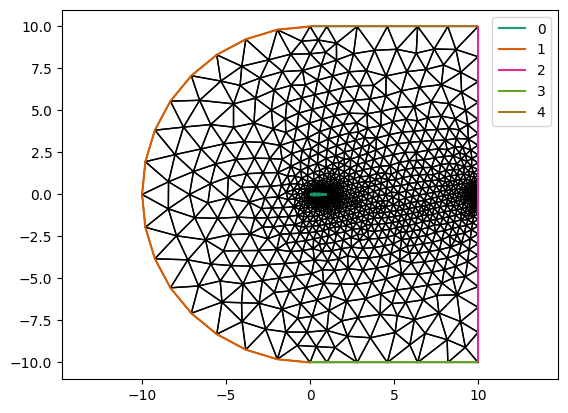

In [ ]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.legend()

(-0.35, 0.35)

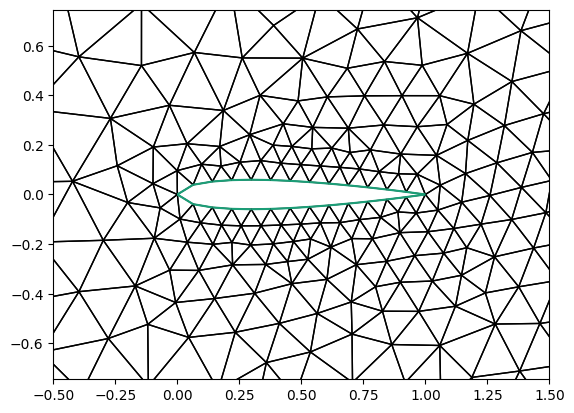

In [ ]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)

# Solve problem with SUPG N-S with Stokes starting point

## Solve stokes to obtain a starting point

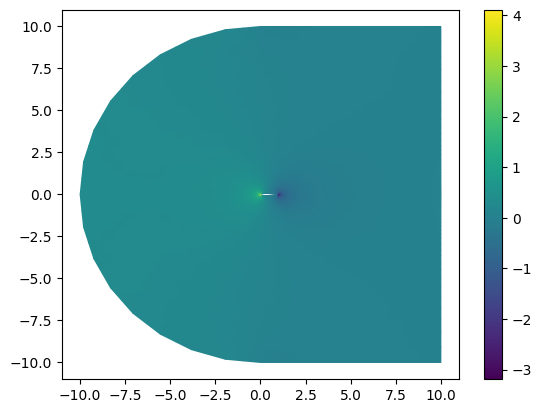

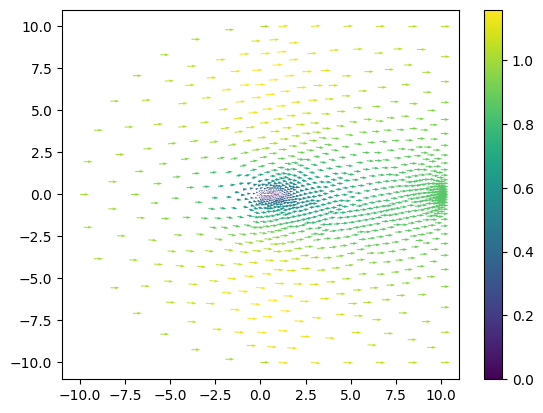

In [ ]:
# function space
V=VectorFunctionSpace(M, 'P', 2) # velocity
Q=FunctionSpace(M, 'P', 1) # pressure
W=MixedFunctionSpace([V, Q])

# trial and test functions
u, p=TrialFunctions(W)
v, q=TestFunctions(W)

# data
x=SpatialCoordinate(M)
Uinf=as_vector([1,0])

# problem
a=inner(grad(u), grad(v))*dx - p*div(v)*dx+ q*div(u)*dx
L=inner(Constant((0,0)),v)*dx

# Dirichlet BC
bc1=DirichletBC(W.sub(0), as_vector([0,0]), 0)
bc2=DirichletBC(W.sub(0), Uinf, 1)
bcs=(bc1, bc2)

#solution
w_stokes=Function(W)
solve(a==L, w_stokes, bcs=bcs)
# u_h, p_h=split(wh) no split command works only for trial and test funtion
u_stokes, p_stokes=w_stokes.subfunctions

fig, ax = plt.subplots()
q=tripcolor(p_stokes, axes=ax)
fig.colorbar(q)
fig, ax = plt.subplots()
q=quiver(u_stokes, axes=ax)
fig.colorbar(q)

## Set Reynolds Number


In [ ]:
Re = Constant(3500)

## Solve Navier Stokes with SUPG Stabilization

In [ ]:
def a(u,v, Re):
    return 1/Re*inner(grad(u), grad(v))*dx

def c(w,u,v):
    return inner(dot(grad(u), w),v)*dx

def b(v,q):
    return -q*div(v)*dx

def stabilization(u_old, u, p, v, q, M, Re):
    ubar = Function(FunctionSpace(M, 'DG', 0))
    ubar.project(sqrt(inner(u_old, u_old)))
    h = CellDiameter(M)
    Re_K = h * ubar * Re
    one  = Constant(1.0)
    delta=Constant(1.0)
    delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

    L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
    Lss = dot(grad(u_old),v) + dot(grad(v),u_old) + grad(q)+ 0.5*div(u_old)*v

    lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
    rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

    return lhs, rhs


In [ ]:
# Function spaces (mixed formulation)
V = VectorFunctionSpace(M, 'P', 2)
Q = FunctionSpace(M, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and boundary conditions
f = Constant((0.,0.))

u_in = as_vector([1., 0.])

bc1 = DirichletBC(W.sub(0), Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
bc2 = DirichletBC(W.sub(0), u_in, 1) # Dirichlet unitary B.C. on the inflow boundary
bc3 = DirichletBC(W.sub(1), 0, 0) # Dirichlet unitary B.C. on the inflow boundary
bcs = (bc1, bc2)

In [ ]:
# Trial and test functions
u, p = TrialFunctions(W) # trial functions
v, q = TestFunctions(W) # test functions

param = {'ksp_type':'gmres',
         'ksp_pc_type':'ilu',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
         'snes_rtol':1e-3,
         'snes_maxit':100,
       }

# solution
wh = Function(W)
uh, ph = wh.subfunctions
wh.assign(w_stokes) #initialization with stokes solution

maxit=100
tol=1e-8
it=0
err=tol+1
delta=1

u_old = Function(V)
u_old.assign(uh)
p_old = Function(Q)
p_old.assign(ph)



while it < maxit and err > tol:
  lhs, rhs = stabilization(u_old, u, p, v, q, M, Re)
  G = a(u,v,Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
  L = inner(f,v)*dx +rhs + c(u_old, u_old,v)
  pb = LinearVariationalProblem(G, L , wh, bcs=bcs)
  solver = LinearVariationalSolver(pb, solver_parameters=param)
  solver.solve()
  uh, ph = wh.subfunctions
  err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(ph, p_old, 'L2') / norm(p_old, 'L2'))
  u_old.assign(uh)
  p_old.assign(ph)
  it+=1

print(it)

21


## Plotting the solution

In [ ]:
uh, ph = wh.subfunctions
outfileU = File("output/velocity.pvd")
outfileP = File("output/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)

/Users/guidopoletti/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


(-3.0, 3.0)

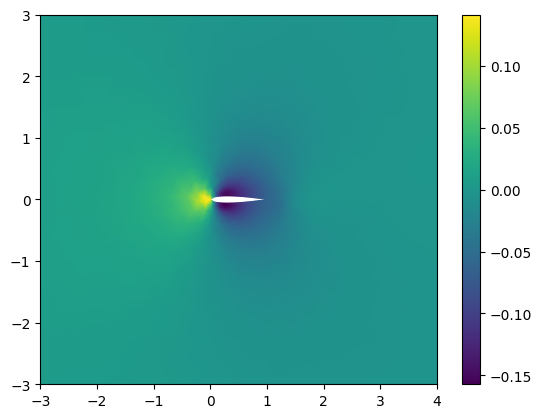

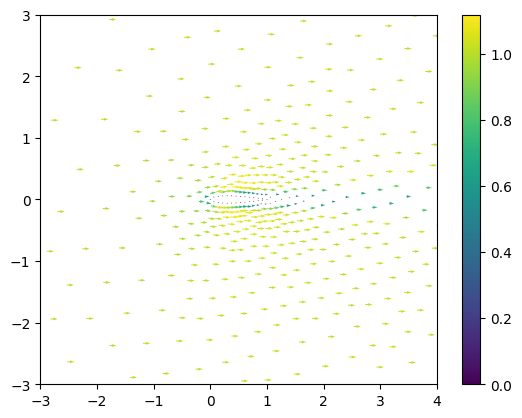

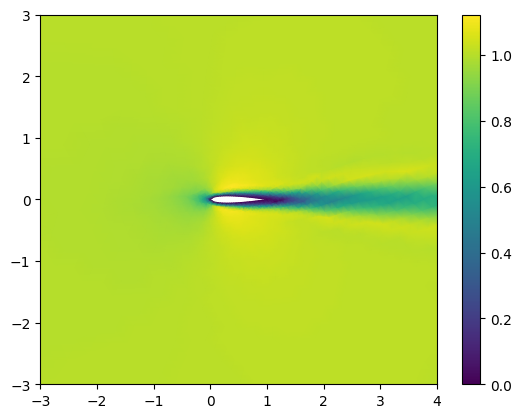

In [ ]:
u_h, p_h = wh.subfunctions
fig, ax = plt.subplots()
q=tripcolor(p_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=quiver(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=tripcolor(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

## Computing lift and drag coefficients

In [ ]:
T=p_h * Identity(2) - 1/Re * (grad(u_h) + grad(u_h).T)
n=FacetNormal(M)
Cd=assemble(inner(T*n, as_vector([1,0]))*ds(0))/0.5
Cl=assemble(inner(T*n, as_vector([0,1]))*ds(0))/0.5
print(Cd)
print(Cl)

0.035144581334309
0.0010676623510121484


# Mesh deformation

## Node Extraction

In [552]:
coord=M.coordinates.dat.data
coord.shape

(1171, 2)

In [553]:
#extend coord to make it work with FFD
coord = np.c_[coord,np.ones(coord.shape[0])]

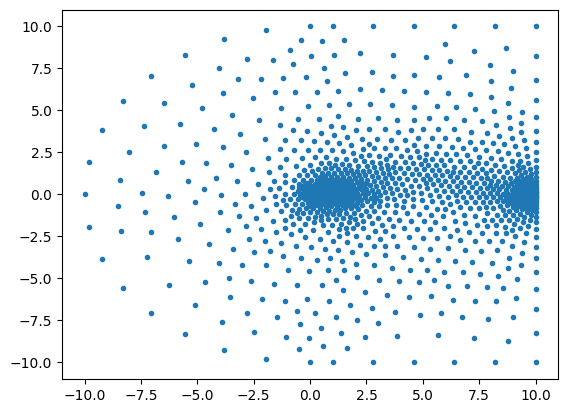

In [554]:
plt.plot(coord[:,0], coord[:,1], '.')

In [555]:
X = VectorFunctionSpace(M, 'P', 1)

b1 = DirichletBC(X, Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
b2 = DirichletBC(X, Constant((0.,0.)), [1, 2, 3, 4]) # Dirichlet unitary B.C. on the inflow boundary


(np.float64(-0.049999999999999996),
 np.float64(1.05),
 np.float64(-0.0653687703999485),
 np.float64(0.06536877039301875))

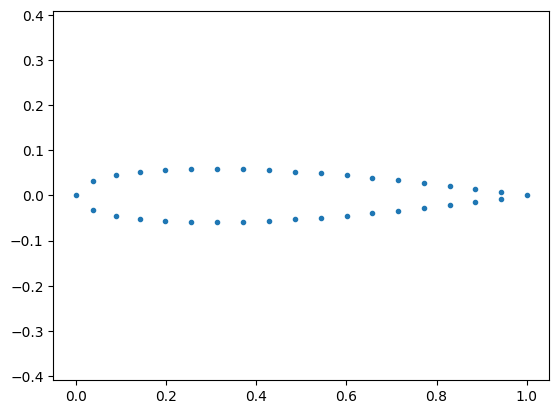

In [556]:
#extract obstacle points
obstacle=coord[b1.nodes, :]
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

(np.float64(-11.0), np.float64(11.0), np.float64(-11.0), np.float64(11.0))

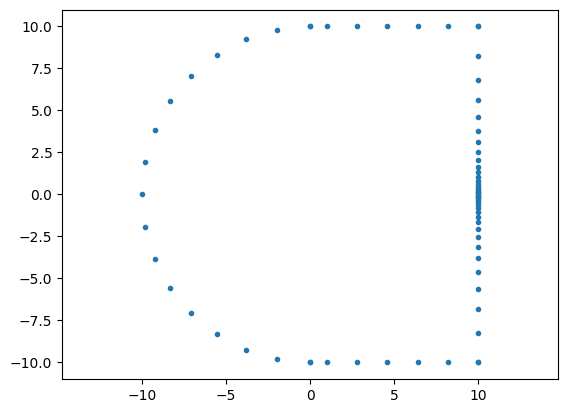

In [557]:
ext_boundary=coord[b2.nodes, :]
plt.plot(ext_boundary[:,0], ext_boundary[:,1], '.')
plt.axis('equal')


## Airfoil deformation

In [558]:
ffd = FFD([6, 2, 1]) #initialize free-form deformation object with the dimensions of the matrix of control points

#define bounding box in which object to deform is contained (position of control points)

ffd.box_origin = np.array([0,-0.5,0.9])
ffd.box_length = np.array([1,1,1.1])


(np.float64(-0.05), np.float64(1.05), np.float64(-0.55), np.float64(0.55))

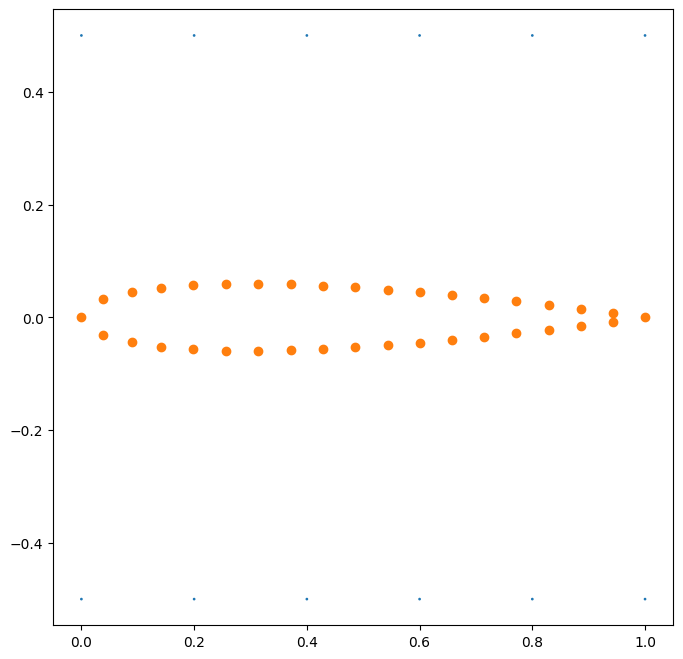

In [559]:
ax = plt.figure(figsize=(8,8)).add_subplot(111)
ax.scatter(*ffd.control_points().T)
ax.scatter(obstacle[:,0],obstacle[:,1])
ax.axis('equal')

In [560]:
#define movement in each direction for each control point

#ffd.array_mu_x[2, 2, 0] = 0.5
ffd.array_mu_y[1:-1,:,0] = -0.02
#ffd.array_mu_z[1, 1, 0] = 0.

(np.float64(-0.0500000000000001),
 np.float64(1.05),
 np.float64(-0.08310392288591392),
 np.float64(0.066213301463779))

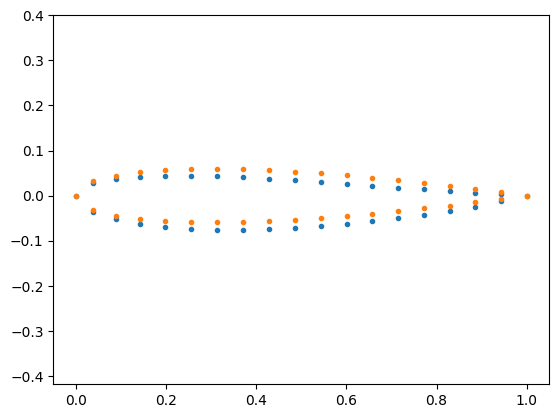

In [561]:
new_obstacle = ffd(obstacle)
plt.plot(new_obstacle[:,0], new_obstacle[:,1], '.')
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

In [562]:
undeformed_points_full = np.vstack([ext_boundary, obstacle])
deformed_points_full= np.vstack([ext_boundary, new_obstacle])

undeformed_points, uindexes = np.unique(undeformed_points_full, return_index=True, axis=0)
deformed_points   = deformed_points_full[uindexes]

rbf = RBF(original_control_points=undeformed_points, deformed_control_points=deformed_points,func='polyharmonic_spline',radius = 0.2)

(np.float64(-11.0), np.float64(11.0), np.float64(-11.0), np.float64(11.0))

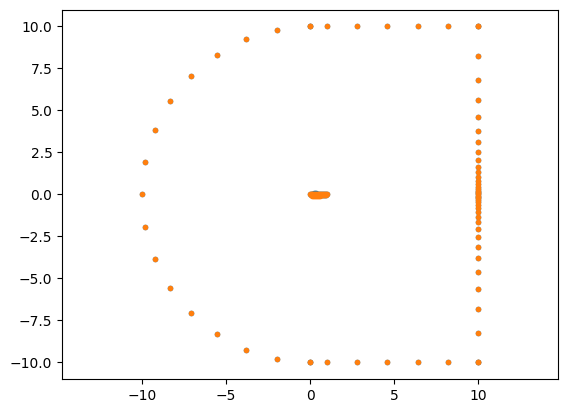

In [563]:
 
plt.plot(undeformed_points_full[:,0],undeformed_points_full[:,1],'.')
plt.plot(deformed_points_full[:,0],deformed_points_full[:,1],'.')
plt.axis('equal')

In [564]:
#propagate deformation to the whole mesh
new_coord=rbf(coord)

(np.float64(-10.999999999999993),
 np.float64(11.000000000000007),
 np.float64(-11.0),
 np.float64(11.0))

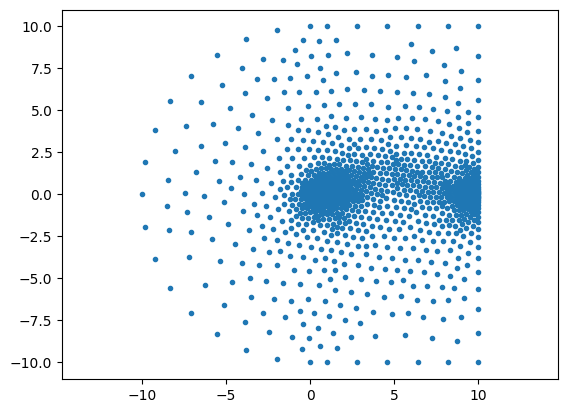

In [565]:
plt.plot(new_coord[:,0], new_coord[:,1], '.')
plt.axis('equal')

In [566]:
new_coords_func = Function(M.coordinates.function_space())
new_coords_func.dat.data[:] = new_coord[:,:2]
M.coordinates.assign(new_coords_func)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x30dfde950>, VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 6512)), 9373)

(-0.35, 0.35)

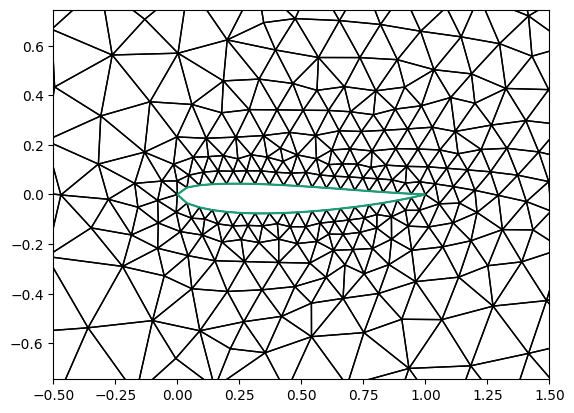

In [567]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)

# Reinforcement learning

## CFD solver

In [9]:
M = Mesh('testairfoil.msh')

# Define files to store the output in

outfileU = VTKFile("velocity.pvd")
outfileP = VTKFile("pressure.pvd")


In [10]:
class CFDSolver:
    def __init__(self, mesh, reynolds_number):
        self.mesh = mesh
        self.Re = reynolds_number

        # Define finite element spaces and mixed formulation (Velocity and Pressure)
        self.V = VectorFunctionSpace(mesh, 'P', 2)
        self.Q = FunctionSpace(mesh, 'P', 1)
        self.W = MixedFunctionSpace([self.V, self.Q])

        # Define data
        self.f=Constant((0.,0.))

        # Define boundary conditions
        self.define_boundary_conditions()

        # Initialize the problem
        self.wh = Function(self.W)  # Solution function (velocity, pressure)
        self.uh, self.ph = self.wh.subfunctions

    def define_boundary_conditions(self):
        u_in = as_vector([1., 0.])
        bc1 = DirichletBC(self.W.sub(0), Constant((0.,0.)), 0) # No-slip on airfoil
        bc2 = DirichletBC(self.W.sub(0), u_in, 1) # Unitary inflow condition
        self.bcs = [bc1, bc2]

    def solve_stokes(self):
        # Define the trial and test functions
        u, p = TrialFunctions(self.W)
        v, q = TestFunctions(self.W)

        # Define the Stokes variational problem (no convective term)
        a_stokes = (1/self.Re) * inner(grad(u), grad(v)) * dx - div(v) * p * dx - q * div(u) * dx
        L_stokes = inner(Constant((0., 0.)), v) * dx  # No external force

        # Solve the Stokes problem
        wh_stokes = Function(self.W)
        init_problem = LinearVariationalProblem(a_stokes, L_stokes, wh_stokes, bcs=self.bcs)
        solver_init =  LinearVariationalSolver(init_problem)
        solver_init.solve()

        # Assign Stokes solution to initial values of Navier-Stokes solver
        self.wh.assign(wh_stokes)
        print("Stokes solution computed and set as initial condition.")

    def run_solver(self):

        def a(u,v, Re):
            return 1/Re*inner(grad(u), grad(v))*dx

        def c(w,u,v):
            return inner(dot(grad(u), w),v)*dx

        def b(v,q):
            return -q*div(v)*dx

        def stabilization(u_old, u, p, v, q, M, Re):
            ubar = Function(FunctionSpace(M, 'DG', 0))
            ubar.project(sqrt(inner(u_old, u_old)))
            h = CellDiameter(M)
            Re_K = h * ubar * Re
            one  = Constant(1.0)
            delta=Constant(1.0)
            delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

            L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
            Lss = dot(skew(grad(u_old)),v) + dot(grad(v),u_old) + grad(q) + 0.5*div(u_old)*v

            lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
            rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

            return lhs, rhs

        # First, solve the Stokes problem for initialization
        self.solve_stokes()

        # Define the trial and test functions
        u, p = TrialFunctions(self.W)
        v, q = TestFunctions(self.W)

        maxit = 1000
        tol = 1e-8
        it = 0
        err = tol + 1

        # Prepare previous solution functions for iterations
        u_old = Function(self.V)
        u_old.assign(self.uh)
        p_old = Function(self.Q)
        p_old.assign(self.ph)

        param = {'ksp_type':'gmres',
         'ksp_pc_type':'ilu',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
       }

        while it < maxit and err > tol:
          it+=1
          lhs, rhs = stabilization(u_old, u, p, v, q, self.mesh, self.Re)
          G = a(u,v,self.Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
          L = inner(self.f,v)*dx + rhs + c(u_old, u_old,v)
          pb = LinearVariationalProblem(G, L , self.wh, bcs=self.bcs)
          solver = LinearVariationalSolver(pb, solver_parameters=param)
          solver.solve()
          self.uh, self.ph = self.wh.subfunctions

          err = (errornorm(self.uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(self.ph, p_old, 'L2') / norm(p_old, 'L2'))

          u_old.assign(self.uh)
          p_old.assign(self.ph)

        if it>maxit:
            print("Max iterations reached")
        else:
            print("Solver converged in", it, "iterations")

        #store the results

        self.uh.rename("Velocity")   # this name will be used in Paraview
        self.ph.rename("Pressure")   # this name will be used in Paraview
        outfileU.write(self.uh)
        outfileP.write(self.ph)

        # Calculate Cd and Cl
        Cd, Cl = self.calculate_drag_lift()
        return Cd, Cl

    def calculate_drag_lift(self):
        T=self.ph * Identity(2) - 1/(self.Re) * (grad(self.uh) + grad(self.uh).T)
        n=FacetNormal(self.mesh)
        Cd=assemble(inner(T*n, as_vector([1,0]))*ds(0))/0.5
        Cl=assemble(inner(T*n, as_vector([0,1]))*ds(0))/0.5
        return Cd, Cl

    def plot_solution(self):
        fig, ax = plt.subplots()
        q=tripcolor(self.ph, axes=ax)
        fig.colorbar(q)
        ax.set_xlim(-3, 4)
        ax.set_ylim(-3, 3)

        fig, ax = plt.subplots()
        q=quiver(self.uh, axes=ax)
        fig.colorbar(q)
        ax.set_xlim(-3, 4)
        ax.set_ylim(-3, 3)

    def get_pressure(self):
        X = VectorFunctionSpace(self.mesh, 'P', 1)
        b1 = DirichletBC(X, Constant((0., 0.)), 0)
        return self.ph.dat.data[b1.nodes]
        

## RL environment

In [11]:
class AirfoilDeformationEnv(gym.Env):
    def __init__(self, initial_mesh, deformation_limits=(-0.1, 0.1)):
        super(AirfoilDeformationEnv, self).__init__()

        # Initialize mesh and CFD solver
        self.initial_mesh = initial_mesh
        self.mesh = Mesh(initial_mesh)
        self.cfd_solver = CFDSolver(self.mesh, 3500)
        self.deformation_limits = deformation_limits

        #Initialize undeformed points

        self.coord = self.mesh.coordinates.dat.data
        self.coord = np.c_[self.coord, np.ones(self.coord.shape[0])]
        X = VectorFunctionSpace(self.mesh, 'P', 1)
        b1 = DirichletBC(X, Constant((0., 0.)), 0)
        b2 = DirichletBC(X, Constant((0., 0.)), [1, 2, 3, 4])

        self.obstacle = self.coord[b1.nodes, :]
        self.ext_boundary = self.coord[b2.nodes, :]

        undeformed_points_full = np.vstack([self.ext_boundary, self.obstacle])
        self.undeformed_points, self.uindexes = np.unique(undeformed_points_full, return_index=True, axis=0)

        #Initialize FFD bounding box

        self.ffd = FFD([6, 2, 1])
        self.ffd.box_origin = np.array([0,-0.5,0.9])
        self.ffd.box_length = np.array([1,1,1.1])

        # Define action space
        self.action_space = spaces.Box(
            low=self.deformation_limits[0],
            high=self.deformation_limits[1],
            shape=(4,2), 
            dtype=np.float32
        )
        print("Action space initialized:", self.action_space)

        self.cfd_solver.run_solver()

        # Define observation space
        self.observation_space = spaces.Box(
            low=-1, high=1,
            shape=self.cfd_solver.get_pressure().shape,
            dtype=np.float32
        )
        print("Observation space initialized:", self.observation_space)

        self.reset()

    def step(self, action):
        print("Action received in step:")
        print(action)

        # Check if action contains NaNs
        if np.isnan(action).any():
            raise ValueError("NaN detected in action!")

        # Perform mesh deformation

        self.mesh_deformation(action)
        self.cfd_solver = CFDSolver(self.mesh, 3500)

        # Compute Cd and Cl using CFD solver
        t = time.time()
        Cd, Cl = self.cfd_solver.run_solver()
        #self.cfd_solver.plot_solution()
        print("time spent for solution: ", time.time() - t)

        # Calculate reward
        reward = self.calculate_reward(Cd, Cl)
        done = False  # Continual optimization

        # Observation from mesh coordinates
        observation = self.cfd_solver.get_pressure()
        if np.isnan(observation).any():
            raise ValueError("NaN detected in observation after step!")
        #print("Observation after step:")
        #print(observation)

        return observation, reward, done, {}

    def reset(self):
        print("Resetting environment and mesh")
        self.mesh = Mesh(self.initial_mesh)

        # Confirm no NaNs in reset mesh coordinates
        observation = self.cfd_solver.get_pressure()
        if np.isnan(observation).any():
            raise ValueError("NaN detected in mesh coordinates after reset!")

        return observation

    def mesh_deformation(self, parameters):

        t = time.time()

        #Reset mesh
        
        self.mesh = Mesh(self.initial_mesh)

        print("Deforming mesh with parameters:")
        print(parameters)

        if np.isnan(parameters).any():
            raise ValueError("NaN detected in deformation parameters!")

        #Apply FFD
        
        self.ffd.array_mu_y[1:-1,:,0] = parameters


        # Apply RBF
        new_obstacle = self.ffd(self.obstacle)
        #plt.plot(new_obstacle[:,0], new_obstacle[:,1], '.')
        #plt.plot(obstacle[:,0], obstacle[:,1], '.')
        #plt.axis('equal')
        deformed_points_full = np.vstack([self.ext_boundary, new_obstacle])
        deformed_points = deformed_points_full[self.uindexes]
        rbf = RBF(original_control_points=self.undeformed_points, deformed_control_points=deformed_points, func = 'polyharmonic_spline', radius = 0.2)
        new_coord = rbf(self.coord)

        # Update mesh
        new_coords_func = Function(self.mesh.coordinates.function_space())
        new_coords_func.dat.data[:, :2] = new_coord[:, :2]
        self.mesh.coordinates.assign(new_coords_func)

        print("time spent for deformation: ", time.time() - t)

    def calculate_reward(self, Cd, Cl):
        rw = Cl/Cd
        print("lift: ",Cl)
        print("drag: ",Cd)
        print("Reward: ",rw)
        return rw
    
    


# Reinforcement Learning

## Setting up environment and agent

In [12]:
# Define initial mesh and control points of the airfoil
initial_mesh ="testairfoil.msh"

# Create the environment with the CFD solver, initial mesh, and control points
env3 = AirfoilDeformationEnv(initial_mesh)

# Create the PPO agent
model = PPO("MlpPolicy", env3, verbose=1)

Action space initialized: Box(-0.1, 0.1, (4, 2), float32)
Stokes solution computed and set as initial condition.
Solver converged in 17 iterations
Observation space initialized: Box(-1.0, 1.0, (26,), float32)
Resetting environment and mesh
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


## Model Training

In [14]:
# Train the agent
model.learn(total_timesteps=100)

# Save the trained model

model.save('PPOairfoil.zip')

Resetting environment and mesh
Action received in step:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.00533229]]
Deforming mesh with parameters:
[[-0.1        -0.1       ]
 [-0.1        -0.1       ]
 [-0.1         0.1       ]
 [ 0.1        -0.00533229]]
time spent for deformation:  0.0157010555267334
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 22 iterations
time spent for solution:  2.0778942108154297
lift:  0.005226691463824015
drag:  0.052891576625231154
Reward:  0.0988189764290501
Action received in step:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [ 0.1  0.1]
 [ 0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009919166564941406
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 20 iterations
time spent for solution:  1.8740248680114746
lift:  0.100973828617839
drag:  0.05781979668154159
Reward:  1.7463539205089236
Action received in step:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
Deforming mesh with parameters:
[[ 0.1 -0.1]
 [-0.1 -0.1]
 [ 0.1 -0.1]
 [ 0.1 -0.1]]
time spent for deformation:  0.010182857513427734
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.6985630989074707
lift:  -0.03850004344900067
drag:  0.042462219205638474
Reward:  -0.9066893857466668
Action received in step:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
Deforming mesh with parameters:
[[-0.1 -0.1]
 [-0.1 -0.1]
 [-0.1  0.1]
 [-0.1  0.1]]
time spent for deformation:  0.009985923767089844
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


KeyboardInterrupt: 

## Model Testing

In [18]:
# Load the trained model

model = model.load('PPOairfoil.zip', force_reset = True)

# Reset environment to get initial state
obs = env3.reset()

# Run the PPO agent to deform the airfoil contour
action, _states = model.predict(obs, deterministic=True)
obs, reward, done, info = env3.step(action)

Resetting environment and mesh
Action received in step:
[[0.00626682 0.1       ]
 [0.1        0.1       ]
 [0.06832191 0.07600628]
 [0.02726702 0.01945041]]
Deforming mesh with parameters:
[[0.00626682 0.1       ]
 [0.1        0.1       ]
 [0.06832191 0.07600628]
 [0.02726702 0.01945041]]
time spent for deformation:  0.018110990524291992
Stokes solution computed and set as initial condition.


/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: divide by zero encountered in log
  np.power(r_sc, k) * np.log(r_sc))
/Users/guidopoletti/firedrake/lib/python3.11/site-packages/pygem-2.0.0-py3.11.egg/pygem/rbf_factory.py:163: RuntimeWarning: invalid value encountered in multiply
  np.power(r_sc, k) * np.log(r_sc))


Solver converged in 18 iterations
time spent for solution:  1.596952199935913
lift:  0.12899993774078009
drag:  0.04823550607192231
Reward:  2.6743772014837512
